In [5]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
!pip install torch


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
      

In [6]:
from datetime import datetime
import time
import pandas as pd
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch_geometric.data import DataLoader

from multichannel_spatiotemporal import STGCN
from london_dataset import LondonBikeDataset

1.9.0+cu102


In [7]:
def main(max_epochs, path_model_save, path_model_load, update_saved_model_freq,
         dataset_kwargs, dataloader_kwargs, model_kwargs, optimizer_kwargs,trail_name):
    '''
    Main function to train model on a dataset. Saves the model state to disk as it progresses.

    Args:
        max_epochs (int): Maximum number of epochs in the training
        path_model_save (str): Path to save model. Include up to filename prefix, e.g. `/my_computer/my_dir/file`
        path_model_load (str): Path to model to load state from. If None, state is randomly initialized.
        update_saved_model_freq (int): How many optimization steps between updates to the saved model.
        dataset_kwargs (dict): Keyworded arguments for the creation of a LondonBikeDataset instance
        dataloader_kwargs (dict): Keyworded arguments for the creation of a PyTorch geometric DataLoader instance
        model_kwargs (dict): Keyworded arguments for the spatio-temporal graph convolutional net model instance
        optimizer_kwargs (dict): Keyworded arguments for the SGD optimizer used for the training

    '''
    #device = xm.xla_device(n=8, devkind='TPU')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     with open(path_model_save+'_input_params'+'.txt', 'w') as fout:
#         print ('Training start:{}\n'.format(datetime.now().isoformat()), file=fout)
#         print ('dataset kwargs:\n {}\n'.format(dataset_kwargs), file=fout)
#         print ('dataloader kwargs:\n {}\n'.format(dataloader_kwargs), file=fout)
#         print ('model kwargs:\n {}\n'.format(model_kwargs), file=fout)
#         print ('optimizer kwargs:\n {}'.format(optimizer_kwargs), file=fout)

    london_bike_data = LondonBikeDataset(**dataset_kwargs)
    london_bike_loader = DataLoader(london_bike_data, **dataloader_kwargs)
    if 'create_from_source' in dataset_kwargs:
        if dataset_kwargs['create_from_source']:
            london_bike_data.write_creation_params()

    model = STGCN(n_spatial_dim=london_bike_data[0].num_nodes, **model_kwargs).to(device)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)

    if not path_model_load is None:
        state = torch.load(path_model_load)
        model.load_state_dict(state['model_state_dict'])
        optimizer.load_state_dict(state['optimizer_state_dict'])
    train_loss=pd.DataFrame()
    start_time=time.time()
    model.train()
    for epoch in range(max_epochs):
        print ('Epoch {} at {}'.format(epoch, datetime.now().isoformat()))

        for k_batch, local_batch in enumerate(london_bike_loader):
            local_batch = local_batch.to(device)
            optimizer.zero_grad()

            #print ('Shape of batch {}: {}'. format(k_batch, local_batch.x.shape))
            out = model(local_batch)
            #print ('...model evaluated at {}'.format(datetime.now().isoformat()))
            loss = F.mse_loss(out.y, local_batch.y)
            #print ('...with loss {} at {}'.format(loss, datetime.now().isoformat()))
            loss.backward()
            #print ('...gradients done at {}'.format(datetime.now().isoformat()))
            optimizer.step()
            #print ('...optimization step done at {}'.format(datetime.now().isoformat()))
            end_time=time.time()
            acc_time=round(end_time-start_time,2)
            train_loss=train_loss.append({'epoch':int(epoch),'batch':int(k_batch),'loss':loss,'time_acc':acc_time},ignore_index=True)
            
            train_loss.to_csv('/project/model_train_result_15mins_s16000/'+trail_name+str(trail_time+1)+'.csv')
            if k_batch % update_saved_model_freq == 0:
                # Save model and optimizer states rather than the entire model.
                torch.save({'epoch': epoch,
                            'k_batch': k_batch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss},
                            path_model_save + '.tar')

In [63]:
#hello=pd.read_csv('/project/data_15(3).csv')
(35519/12)*2
7000/35519
(28520,35519)

(28520, 35519)

In [8]:
from consts import EXCLUDE_STATIONS
def trail(lower_weight,trail_name,batch,epochs,samplesize,trail_time):
  dataset_kwargs = {'lower_weight' : lower_weight,
                    'common_weight' : None,
                    'time_id_bounds' :(0,28519),
                    'time_shuffle' : True,
                    'sample_size' :samplesize,
                    'create_from_source' :True,
                    'station_exclusion' : EXCLUDE_STATIONS,
                    'ntimes_leading' : 5,
                    'ntimes_forward' : 1,
                    'source_graph_file' : 'graph_weight_15(3).csv',
                    'source_data_files' : 'data_15(3).csv',
                    'root_dir' : '/project/data_input',
                    'source_dir' : '/project',
                    'weight_type':'percent_flow',
                    'seed':1}

  dataloader_kwargs = {'batch_size' : batch, 'shuffle' : True}

  model_kwargs = {'n_temporal_dim' : 5, 'n_input_channels' : 2,
                  'co_temporal' :64, 'co_spatial' :16, 'time_conv_length' : 3}
  optimizer_kwargs = {'lr':0.01, 'momentum': 0.9}
  max_epochs = epochs
  path_model_save = '/project/model_save_15mins_s16000/'+trail_name+str(trail_time+1)
  if trail_time==0:
    path_model_load = None
  else:
    path_model_load = '/project/model_save_15mins_s16000/'+trail_name+str(trail_time)+'.tar'
  model=main(max_epochs,path_model_save, path_model_load, 3, 
             dataset_kwargs, dataloader_kwargs, model_kwargs, optimizer_kwargs,trail_name)

In [ ]:
for trail_time in range(6,10):
    trail(0.3,'d15_w03_b64_e10_s16000_stgcn_v',64,10,16000,trail_time)
    print('|'+'-'*30+'|')
    print('|Well Done! Finished trail '+str(trail_time+1)+'!! |')
    print('|'+'-'*30+'|')

In [67]:
print('hello world')

hello world


In [92]:
hello=pd.read_csv('/project/data_15(2).csv')
hello

,station_id,time_id,arrivals,departures
0,1,0,0,0
1,2,0,0,0
2,3,0,0,1
3,4,0,0,0
4,5,0,0,0
...,...,...,...,...
26562971,830,35519,0,0
26562972,831,35519,0,0
26562973,833,35519,0,0
26562974,838,35519,0,0


In [58]:
hello[hello.time_id==27552]

,station_id,time_id,arrivals,departures
20602912,1,27552,0,0
20602913,2,27552,0,1
20602914,3,27552,0,0
20602915,4,27552,0,0
20602916,5,27552,0,0
...,...,...,...,...
20603655,830,27552,0,0
20603656,831,27552,0,0
20603657,833,27552,0,0
20603658,838,27552,0,0


In [94]:
time_id=set(hello.time_id.unique())
se=set([i for i in range(0,35520)])

retD = list(se.difference(time_id))
retD

[27544, 27545, 27546, 27547, 27548, 27549, 27550, 27551]

In [76]:
6886/(24*286)


1.0032051282051282

In [14]:
hello1=pd.read_csv('/project/data.csv')
hello1

,station_id,time_id,arrivals,departures
0,1,49728,0,1
1,2,49728,0,0
2,3,49728,0,0
3,4,49728,0,0
4,5,49728,0,0
...,...,...,...,...
15489787,833,70463,0,0
15489788,834,70463,0,0
15489789,835,70463,0,0
15489790,838,70463,0,0


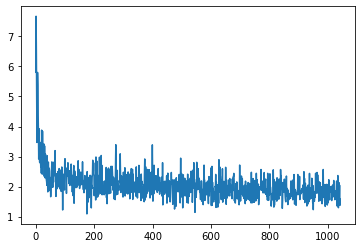

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
loss_data=pd.read_csv('/project/model_train_result/data30_w045+b64+e100+s6400_v1.csv')
loss_data.shape

for i in range(loss_data.shape[0]):
    loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])
y=np.array(loss_data.loss)
x=np.array(loss_data.index)
plt.plot(x,y)

,Unnamed: 0,batch,epoch,loss,time_acc
0,0,0.0,0.0,"tensor(0.8523, device='cuda:0', grad_fn=<MseLo...",3.61
1,1,1.0,0.0,"tensor(0.7859, device='cuda:0', grad_fn=<MseLo...",7.29
2,2,2.0,0.0,"tensor(0.6287, device='cuda:0', grad_fn=<MseLo...",10.84
3,3,3.0,0.0,"tensor(0.8419, device='cuda:0', grad_fn=<MseLo...",14.43
4,4,4.0,0.0,"tensor(0.6973, device='cuda:0', grad_fn=<MseLo...",18.14
...,...,...,...,...,...
1395,1395,95.0,13.0,"tensor(0.4658, device='cuda:0', grad_fn=<MseLo...",5786.53
1396,1396,96.0,13.0,"tensor(0.4348, device='cuda:0', grad_fn=<MseLo...",5791.09
1397,1397,97.0,13.0,"tensor(0.5494, device='cuda:0', grad_fn=<MseLo...",5795.88
1398,1398,98.0,13.0,"tensor(0.5220, device='cuda:0', grad_fn=<MseLo...",5800.63


In [4]:
def each_epoch_summary(loss_data):
    for i in range(loss_data.shape[0]):
        loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])
    loss_data.loss=loss_data.loss.astype(float)
    loss_data.epoch=loss_data.epoch.astype(int)
    loss_data.batch=loss_data.batch.astype(int)
    gb=loss_data.groupby(by='epoch').mean()
    return gb

In [8]:
import numpy as np
import matplotlib.pyplot as plt
full_loss_data=pd.read_csv('/project/model_train_result/data30_w045+b64+e100+s6400_v1.csv')
full_loss_data=each_epoch_summary(full_loss_data)

for i in range(2,18):
    loss_data=pd.read_csv('/project/model_train_result/w045+b64+e15+s6400_v'+str(i)+'.csv')
    loss_data=each_epoch_summary(loss_data)
    full_loss_data=full_loss_data.append(loss_data)
full_loss_data.shape

# y=np.array(gb.loss)
# x=np.array(gb.index)
# plt.plot(x,y)

(236, 4)

In [9]:
full_loss_data

,Unnamed: 0,batch,loss,time_acc
epoch,,,,
0,49.5,49.5,2.756984,251.5656
1,149.5,49.5,2.210948,753.7659
2,249.5,49.5,2.118060,1259.5175
3,349.5,49.5,2.073824,1775.5062
4,449.5,49.5,2.012371,2298.3428
...,...,...,...,...
9,949.5,49.5,0.537174,3789.9555
10,1049.5,49.5,0.531906,4226.3459
11,1149.5,49.5,0.527332,4669.2546


In [7]:
#full_loss_data=full_loss_data.reset_index()
y=np.array(full_loss_data.loss)
x=np.array(full_loss_data.index)
x
# plt.plot(x,y,color='#37A27F', linewidth=1.5, linestyle='-')
# plt.xlabel('training epoch',fontdict={ 'size': 13})
# plt.ylabel('loss',fontdict={'size': 13})
# plt.title('The training loss of the Graph CNN model')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13,  0,  1,  2,  3

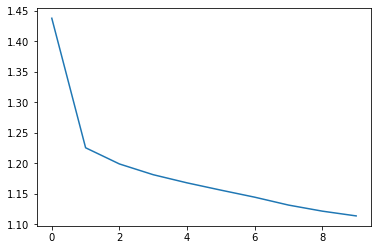

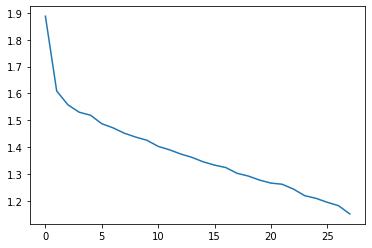

In [11]:
import numpy as np
import matplotlib.pyplot as plt
loss_data=pd.read_csv('/project/model_train_result/d15_w03_b64_e30_s6400_stgcn_v1.csv')
loss_data.shape

for i in range(loss_data.shape[0]):
    loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])
loss_data.loss=loss_data.loss.astype(float)
loss_data.epoch=loss_data.epoch.astype(int)
loss_data.batch=loss_data.batch.astype(int)
gb=loss_data.groupby(by='epoch').mean()
y=np.array(gb.loss)
x=np.array(gb.index)
plt.plot(x,y)

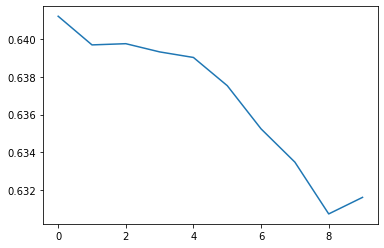

In [78]:
import numpy as np
import matplotlib.pyplot as plt
loss_data=pd.read_csv('/project/model_train_result/d15_w03_b64_e10_s6400_stgcn_v12.csv')
loss_data.shape

for i in range(loss_data.shape[0]):
    loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])
loss_data.loss=loss_data.loss.astype(float)
loss_data.epoch=loss_data.epoch.astype(int)
loss_data.batch=loss_data.batch.astype(int)
gb=loss_data.groupby(by='epoch').mean()
y=np.array(gb.loss)
x=np.array(gb.index)
plt.plot(x,y)

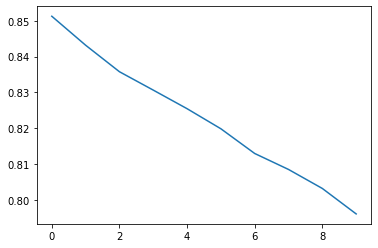

In [43]:
import numpy as np
import matplotlib.pyplot as plt
loss_data=pd.read_csv('/project/model_train_result/d15_w03_b64_e10_s6400_stgcn_v5.csv')
loss_data.shape

for i in range(loss_data.shape[0]):
    loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])
loss_data.loss=loss_data.loss.astype(float)
loss_data.epoch=loss_data.epoch.astype(int)
loss_data.batch=loss_data.batch.astype(int)
gb=loss_data.groupby(by='epoch').mean()
y=np.array(gb.loss)
x=np.array(gb.index)
plt.plot(x,y)

In [15]:
loss_data.iloc[2000,:]

Unnamed: 0    2000.0000
batch            0.0000
epoch           20.0000
loss             0.9462
time_acc      5341.7300
Name: 2000, dtype: float64

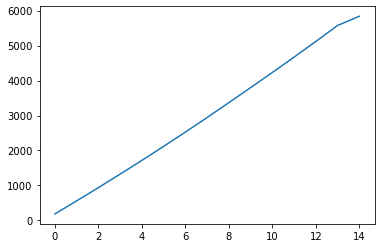

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
loss_data=pd.read_csv('/project/model_train_result/w045+b64+e15+s6400_v2.csv')
loss_data
for i in range(loss_data.shape[0]):
    loss_data.iloc[i,3]=float(loss_data.iloc[i,3][7:13])

loss_data.loss=loss_data.loss.astype(float)
loss_data.batch=loss_data.batch.astype(int)
loss_data.epoch=loss_data.epoch.astype(int)

gb=loss_data.groupby(by='epoch').mean()

y=np.array(gb.time_acc)
x=np.array(gb.index)
plt.plot(x,y)

In [ ]:
trail(0.25,'t15+w025+b64+e10+s20480',64,10,20480)

In [ ]:
trail(0.3,'t15+w030+b128+e10+s20480',128,10,20480)

# New Section

In [ ]:
while True:pass

In [ ]:
trail(0.7,'t15+w0.7+b128+e10+s19200',128,10,19200)

In [ ]:
trail(1.5,'t15+w1.5+b128+e10+s19200',128,10,19200)

In [ ]:
trail(3,'t15+w3+b128+e10+s19200',128,10,19200)

In [ ]:
hello=pd.read_csv('/content/drive/MyDrive/london_bike_forecast/model_save/model_save_interrval15')
hello

,Unnamed: 0,batch,epoch,loss,time_acc
0,0,0.0,0.0,"tensor(1.1406, grad_fn=<MseLossBackward>)",60.24


In [ ]:
'''Script for evaluating the London bike forecast graph convolutional neural net
'''
import pandas as pd
def make_viz_stations(model, data_loader, viz_stations, station2id):

    inds = [station2id[k] for k in viz_stations]
    inds_slicer = [[ind * 2, ind *2 + 1] for ind in inds]
    inds_slicer = torch.tensor(inds_slicer).flatten()
    totals_predict = []
    totals_actual = []
    for n_time, data in enumerate(data_loader):
        predict = model(data).y
        actual = data.y
        v_predict = torch.take(predict, inds_slicer)
        v_actual = torch.take(actual, inds_slicer)
        totals_predict.extend(list(v_predict))
        totals_actual.extend(list(v_actual))

    mind = pd.MultiIndex.from_product([['arrivals', 'departures'], range(n_time + 1), viz_stations],
                                      names=['event_type', 'local_time_id', 'station_id'])
    df_1 = pd.DataFrame(totals_actual, index=mind, columns=['actual_count'])
    df_2 = pd.DataFrame(totals_predict, index=mind, columns=['predicted_count'])
    df = df_1.join(df_2)
    return df

def main(path_model_load, dataset_kwargs, dataloader_kwargs, model_kwargs,
         viz_stations=None):
    '''
    Main function to evaluate model on a dataset.

    Args:
        path_model_load (str): Path to model to load state from. If None, state is randomly initialized.
        dataset_kwargs (dict): Keyworded arguments for the creation of a LondonBikeDataset instance
        dataloader_kwargs (dict): Keyworded arguments for the creation of a PyTorch geometric DataLoader instance
        model_kwargs (dict): Keyworded arguments for the spatio-temporal graph convolutional net model instance

    '''
    device = torch.device('tpu')#'cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare the data set and data loader. Dataset preparation can take time and with care taken, the
    # process set to False will reuse already processed files. The meaning of the processed files are
    # currently a manual process, which I could automate later, so use process=True unless you are
    # really sure what you are doing
    london_bike_data = LondonBikeDataset(**dataset_kwargs)
    london_bike_loader = DataLoader(london_bike_data, **dataloader_kwargs)

    # Initialize model and load state
    model = STGCN(n_spatial_dim=london_bike_data[0].num_nodes, **model_kwargs).to(device)
    state = torch.load(path_model_load)
    model.load_state_dict(state['model_state_dict'])
    model.eval()

    if not viz_stations is None:
        hello=make_viz_stations(model, london_bike_loader, viz_stations, london_bike_data.station_id_2_node_id_map)
    
    return hello


if __name__ == '__main__':

    dataset_kwargs = {'lower_weight' : 0.45,
                      'common_weight' : None,
                      'time_id_bounds' :None,
                      'time_shuffle' : True,
                      'sample_size' :50,
                      'create_from_source' :True,#'station_exclusion' : EXCLUDE_STATIONS,
                      'ntimes_leading' : 9,
                      'ntimes_forward' : 5,
                      'source_graph_file' : 'graph_weight.csv',
                      'source_data_files' : 'data.csv',
                      'root_dir' : '/content/drive/MyDrive/london_bike_forecast/data_input',
                      'source_dir' : '/content/drive/MyDrive/london_bike_forecast',
                      'weight_type':'percent_flow'}

  
    dataloader_kwargs = {'batch_size' : 128, 'shuffle' : False}

    model_kwargs = {'n_temporal_dim' : 9, 'n_input_channels' : 2,
             'co_temporal' :64, 'co_spatial' :16, 'time_conv_length' : 3}

    hello=main(path_model_load='/content/drive/MyDrive/london_bike_forecast/model_save.tar',
         dataset_kwargs=dataset_kwargs, dataloader_kwargs=dataloader_kwargs, model_kwargs=model_kwargs,
         viz_stations=[14])
    print('something will be printed out')
    print(hello)


something will be printed out
                                     actual_count                           predicted_count
event_type local_time_id station_id                                                        
arrivals   0             14                   0.0  tensor(0.3422, grad_fn=<UnbindBackward>)
           1             14                   5.0  tensor(0.3692, grad_fn=<UnbindBackward>)
           2             14                   0.0  tensor(0.2955, grad_fn=<UnbindBackward>)
           3             14                   0.0  tensor(0.3801, grad_fn=<UnbindBackward>)
           4             14                   0.0  tensor(0.2845, grad_fn=<UnbindBackward>)
...                                           ...                                       ...
departures 45            14                   0.0  tensor(0.3983, grad_fn=<UnbindBackward>)
           46            14                   0.0  tensor(0.7329, grad_fn=<UnbindBackward>)
           47            14                   0.0 

# New Section

In [10]:
import pandas as pd
one_file=pd.read_csv('https://cycling.data.tfl.gov.uk/usage-stats/217JourneyDataExtract03Jun2020-09Jun2020.csv')
one_file.loc[:,'StartStation Name'].value_counts()
one_file[one_file.loc[:,'StartStation Name']=='Hyde Park Corner, Hyde Park']

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
937,97924563,1680,217,06/06/2020 17:53,633,"Vereker Road, West Kensington",06/06/2020 17:25,191,"Hyde Park Corner, Hyde Park"
938,97997517,600,15205,08/06/2020 20:52,64,"William IV Street, Strand",08/06/2020 20:42,191,"Hyde Park Corner, Hyde Park"
939,97827149,1080,324,03/06/2020 15:10,153,"Bayswater Road, Hyde Park",03/06/2020 14:52,191,"Hyde Park Corner, Hyde Park"
940,97994196,1140,15335,08/06/2020 19:36,727,"Chesilton Road, Fulham",08/06/2020 19:17,191,"Hyde Park Corner, Hyde Park"
941,97893793,1080,16873,05/06/2020 19:10,74,"Vauxhall Cross, Vauxhall",05/06/2020 18:52,191,"Hyde Park Corner, Hyde Park"
...,...,...,...,...,...,...,...,...,...
151225,97952338,2820,14888,07/06/2020 15:41,329,"Prince Albert Road, The Regent's Park",07/06/2020 14:54,191,"Hyde Park Corner, Hyde Park"
151226,97964295,1620,14185,07/06/2020 18:53,226,"Charles II Street, West End",07/06/2020 18:26,191,"Hyde Park Corner, Hyde Park"
151227,97928783,1380,12916,06/06/2020 22:05,687,"Maclise Road, Olympia",06/06/2020 21:42,191,"Hyde Park Corner, Hyde Park"
151228,97895330,960,9730,05/06/2020 19:42,428,"Exhibition Road, Knightsbridge",05/06/2020 19:26,191,"Hyde Park Corner, Hyde Park"
